In [3]:
import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
from EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

# PyRiemann imports
# from pyriemann.estimation import XdawnCovariances
# from pyriemann.tangentspace import TangentSpace
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt

In [8]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy_lib
import h5py

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

##################### Process, filter and epoch the data ######################
data_path = str(sample.data_path())

# Set parameters and read data
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
tmin, tmax = -0., 1
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

In [5]:
# Setup for reading the raw data
raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method='iir')  # replace baselining with high-pass
events = mne.read_events(event_fname)

raw.info['bads'] = ['MEG 2443']  # set bad channels
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)
labels = epochs.events[:, -1]

# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels

kernels, chans, samples = 1, 60, 151

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB



In [10]:
# take 50/25/25 percent of the data to train/validate/test
X_train      = X[0:144,]
Y_train      = y[0:144]
X_validate   = X[144:208,]
Y_validate   = y[144:208]
X_test       = X[208:,]
Y_test       = y[208:]

############################# EEGNet portion ##################################

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train-1)
Y_validate   = np_utils.to_categorical(Y_validate-1)
Y_test       = np_utils.to_categorical(Y_test-1)

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
   
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (144, 60, 151, 1)
144 train samples
80 test samples


In [20]:
# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
model = EEGNet(nb_classes = 4, Chans = chans, Samples = samples, 
               dropoutRate = 0.5, kernLength = 16, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')

l2_norm_clip = 1.5
noise_multiplier = 0.5 # was 1.3
batch_size = 16
num_microbatches = 1
learning_rate = 0.25
batch_size = 16

optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=1.0,      # Gradient clipping norm
    noise_multiplier=0.5,  # Controls privacy strength (lower = more privacy)
    num_microbatches=num_microbatches, # Use per-example gradients
    learning_rate=0.001
)

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE)



# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
              metrics = ['accuracy'])
print(model.summary())

# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='./tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

###############################################################################
# if the classification task was imbalanced (significantly more trials in one
# class versus the others) you can assign a weight to each class during 
# optimization to balance it out. This data is approximately balanced so we 
# don't need to do this, but is shown here for illustration/completeness. 
###############################################################################

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1, 2:1, 3:1}

################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
# Riemannian geometry classification (below)
################################################################################
fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 300, 
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer], class_weight = class_weights)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 60, 151, 1)]      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 151, 8)        128       
                                                                 
 batch_normalization_33 (Ba  (None, 60, 151, 8)        32        
 tchNormalization)                                               
                                                                 
 depthwise_conv2d_11 (Depth  (None, 1, 151, 16)        960       
 wiseConv2D)                                                     
                                                                 
 batch_normalization_34 (Ba  (None, 1, 151, 16)        64        
 tchNormalization)                                               
                                                          

2025-05-26 09:46:19.044566: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_10/kernel/Assign' id:8249 op device:{requested: '', assigned: ''} def:{{{node dense_10/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_10/kernel, dense_10/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Epoch 1: val_loss improved from inf to 1.38631, saving model to ./tmp/checkpoint.h5
144/144 - 0s - loss: 1.3831 - acc: 0.2431 - val_loss: 1.3863 - val_acc: 0.2344 - 381ms/epoch - 3ms/sample
Epoch 2/300


/opt/anaconda3/envs/zazu2/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.38631 to 1.38628, saving model to ./tmp/checkpoint.h5
144/144 - 0s - loss: 1.3913 - acc: 0.1944 - val_loss: 1.3863 - val_acc: 0.2656 - 122ms/epoch - 851us/sample
Epoch 3/300

Epoch 3: val_loss improved from 1.38628 to 1.38626, saving model to ./tmp/checkpoint.h5
144/144 - 0s - loss: 1.3853 - acc: 0.2639 - val_loss: 1.3863 - val_acc: 0.2656 - 131ms/epoch - 907us/sample
Epoch 4/300

Epoch 4: val_loss did not improve from 1.38626
144/144 - 0s - loss: 1.3787 - acc: 0.2639 - val_loss: 1.3863 - val_acc: 0.2656 - 116ms/epoch - 809us/sample
Epoch 5/300

Epoch 5: val_loss improved from 1.38626 to 1.38624, saving model to ./tmp/checkpoint.h5
144/144 - 0s - loss: 1.3689 - acc: 0.3542 - val_loss: 1.3862 - val_acc: 0.2656 - 123ms/epoch - 855us/sample
Epoch 6/300

Epoch 6: val_loss did not improve from 1.38624
144/144 - 0s - loss: 1.3716 - acc: 0.2917 - val_loss: 1.3863 - val_acc: 0.2656 - 116ms/epoch - 806us/sample
Epoch 7/300

Epoch 7: val_loss did not improve fr

In [22]:
# load optimal weights
model.load_weights('./tmp/checkpoint.h5')

###############################################################################
# can alternatively used the weights provided in the repo. If so it should get
# you 93% accuracy. Change the WEIGHTS_PATH variable to wherever it is on your
# system.
###############################################################################

# WEIGHTS_PATH = /path/to/EEGNet-8-2-weights.h5 
# model.load_weights(WEIGHTS_PATH)

###############################################################################
# make prediction on test set.
###############################################################################

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))


############################# PyRiemann Portion ##############################

# code is taken from PyRiemann's ERP sample script, which is decoding in 
# the tangent space with a logistic regression

# n_components = 2  # pick some components

# # set up sklearn pipeline
# clf = make_pipeline(XdawnCovariances(n_components),
#                     TangentSpace(metric='riemann'),
#                     LogisticRegression())

# preds_rg     = np.zeros(len(Y_test))

# # reshape back to (trials, channels, samples)
# X_train      = X_train.reshape(X_train.shape[0], chans, samples)
# X_test       = X_test.reshape(X_test.shape[0], chans, samples)

# # train a classifier with xDAWN spatial filtering + Riemannian Geometry (RG)
# # labels need to be back in single-column format
# clf.fit(X_train, Y_train.argmax(axis = -1))
# preds_rg     = clf.predict(X_test)

# # Printing the results
# acc2         = np.mean(preds_rg == Y_test.argmax(axis = -1))
# print("Classification accuracy: %f " % (acc2))

Classification accuracy: 0.462500 


In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [25]:
# plot the confusion matrices for both classifiers
names        = ['audio left', 'audio right', 'vis left', 'vis right']
# plt.figure(0)
confusion_matrix_1 = confusion_matrix(preds, Y_test.argmax(axis = -1))

# plt.figure(1)
# confusion_matrix_2 = confusion_matrix(preds_rg, Y_test.argmax(axis = -1))

In [26]:
confusion_matrix_1

array([[16, 15,  4,  4],
       [ 3,  2,  0,  2],
       [ 0,  3, 11,  6],
       [ 0,  1,  5,  8]])

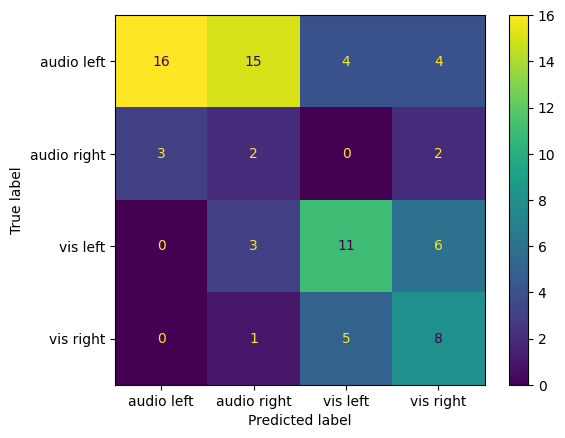

In [27]:
disp1 = ConfusionMatrixDisplay(confusion_matrix_1, display_labels = names)
disp1.plot()

# ConfusionMatrixDisplay(confusion_matrix_2, display_labels = names)

In [30]:
print(classification_report(preds, Y_test.argmax(axis = -1)))

              precision    recall  f1-score   support

           0       0.84      0.41      0.55        39
           1       0.10      0.29      0.14         7
           2       0.55      0.55      0.55        20
           3       0.40      0.57      0.47        14

    accuracy                           0.46        80
   macro avg       0.47      0.45      0.43        80
weighted avg       0.63      0.46      0.50        80



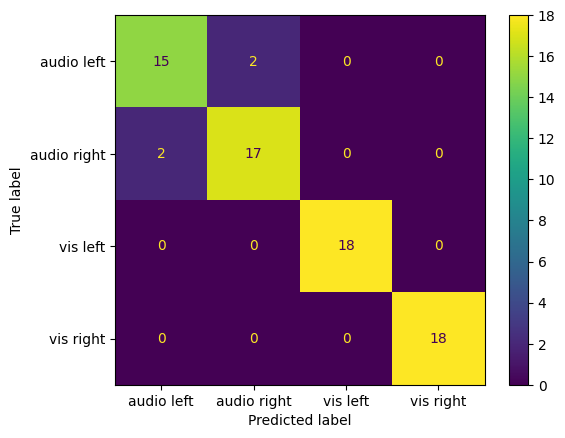

In [24]:
disp2 = ConfusionMatrixDisplay(confusion_matrix_2, display_labels = names)
disp2.plot()